# **Introduction**

This report presents a series of experiments exploring how different design choices affect the performance of convolutional neural networks on two small image classification tasks (a 10-class subset of **CIFAR-100** and the 10-class **Imagenette** dataset). Starting from a simple three-block CNN, we systematically varied the network’s depth and width, swapped activation functions (ReLU, LeakyReLU, Tanh, Sigmoid), tested a range of optimizers and learning rates, and compared different batch sizes and training durations. By measuring test accuracy under each condition, this study reveals which combinations of architecture and hyperparameters yield the best trade-off between learning speed, final accuracy, and over-fitting.

# **I. First experiment** - Using 10 random classes from **CIFAR-100** dataset

## Load the CIFAR-100 data set, select and preprocess 10 clsses to work with

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
y_train = y_train.flatten()
y_test = y_test.flatten()

#Define all CIFAR-100 class names
all_labels = [
    'apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle',
    'bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle',
    'chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur',
    'dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo',
    'keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree',
    'motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree',
    'pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit',
    'raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper',
    'snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank',
    'telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe',
    'whale','willow_tree','wolf','woman','worm'
]

# Select 10 random classes
selected_classes = ['tiger','road','television','train','apple','bottle','bicycle','bed','cup','sea']

# Map names to original indices
class_to_index = {name: idx for idx, name in enumerate(all_labels)}
selected_indices = [class_to_index[name] for name in selected_classes]

# Filter datasets for selected classes
train_mask = np.isin(y_train, selected_indices)
test_mask  = np.isin(y_test,  selected_indices)

x_train_sel = x_train[train_mask]
y_train_sel = y_train[train_mask]
x_test_sel  = x_test[test_mask]
y_test_sel  = y_test[test_mask]

# Re-encode labels to 0-9
new_label_map = {old: new for new, old in enumerate(selected_indices)}
y_train_sel = np.array([new_label_map[l] for l in y_train_sel])
y_test_sel  = np.array([new_label_map[l] for l in y_test_sel])

# Balance dataset: 250 train & 50 test samples per class
def balance(x, y, samples_per_class):
    return (
        np.concatenate([x[y == i][:samples_per_class] for i in range(len(selected_classes))]),
        np.concatenate([y[y == i][:samples_per_class] for i in range(len(selected_classes))])
    )

x_train_final, y_train_final = balance(x_train_sel, y_train_sel, 250)
x_test_final,  y_test_final  = balance(x_test_sel,  y_test_sel,  50)

# Shuffle each subset
def shuffle(x, y):
    p = np.random.permutation(len(x))
    return x[p], y[p]

x_train_final, y_train_final = shuffle(x_train_final, y_train_final)
x_test_final,  y_test_final  = shuffle(x_test_final,  y_test_final)

# Normalize pixel values to [0,1]
x_train_final, x_test_final = x_train_final / 255.0, x_test_final / 255.0

#  One-hot encode labels
y_train_final = to_categorical(y_train_final, num_classes=len(selected_classes))
y_test_final  = to_categorical(y_test_final,  num_classes=len(selected_classes))

# Verify shapes and class distribution
print(f"x_train_final: {x_train_final.shape}, y_train_final: {y_train_final.shape}")
print(f"x_test_final : {x_test_final.shape},  y_test_final : {y_test_final.shape}")


x_train_final: (2500, 32, 32, 3), y_train_final: (2500, 10)
x_test_final : (500, 32, 32, 3),  y_test_final : (500, 10)


## 1. Build a CNN consisting of several convolutional and max pooling layers, several inner dense layers.

- A Sequential CNN with **three convolutional blocks** (32, 64, 128 filters) with 3x3 kernel, each followed by **2×2 max-pooling.**
- **Two fully connected layers** (256 and 128 units) with **ReLU** activations and **50% dropout**.
- The final dense layer uses **softmax** to output class probabilities over the ten categories.
- Compiled with the **Adam optimizer** and categorical cross-entropy loss, tracking accuracy during training.

### 1.1 Model Structure

In [ ]:
from tensorflow.keras import models, layers

# Build the CNN Model
model = models.Sequential([
    # Input shape is 32x32 RGB images
    layers.Input(shape=(32, 32, 3)),

    # First convolutional block: 32 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu'),
    # Max pooling reduces spatial dimensions by 2
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block: 64 filters to learn more complex features
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block: 128 filters for even higher-level representations
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten transforms 3D feature maps to 1D feature vector for dense layers
    layers.Flatten(),

    # First inner dense layer: 256 neurons with ReLU activation
    # Learns combinations of the extracted features
    layers.Dense(256, activation='relu'),
    # Dropout layer to reduce overfitting by randomly dropping 50% of neurons
    layers.Dropout(0.5),

    # Second inner dense layer: 128 neurons with ReLU activation for deeper processing
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer: one neuron per class with softmax activation
    # Softmax produces a probability distribution over 10 classes
    layers.Dense(10, activation='softmax')
])

# Compile the model with optimizer, loss function, and metrics
# 'adam' is a popular adaptive optimizer
# 'categorical_crossentropy' is suitable for multi-class one-hot targets
# We track 'accuracy' during training and evaluation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model structure, output shapes, and parameter counts
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,762 (1010.79 KB)

 Trainable params: 258,762 (1010.79 KB)

 Non-trainable params: 0 (0.00 B)

### 1.2 Train the CNN on the training set

In [ ]:

# Train the CNN model on the training set
# epochs: number of full passes through the training data
# batch_size: number of samples per gradient update
# validation_data: evaluate model on the test set at the end of each epoch
history = model.fit(
    x_train_final,        # training images
    y_train_final,        # training labels (one-hot)
    epochs=25,            # adjust epochs as needed
    batch_size=64,        # typical batch size
    validation_data=(x_test_final, y_test_final)
)

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.1089 - loss: 2.3093 - val_accuracy: 0.1680 - val_loss: 2.1525
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2039 - loss: 2.1465 - val_accuracy: 0.3400 - val_loss: 1.9415
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2799 - loss: 1.9987 - val_accuracy: 0.3660 - val_loss: 1.7940
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3406 - loss: 1.8290 - val_accuracy: 0.4400 - val_loss: 1.6950
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3767 - loss: 1.7439 - val_accuracy: 0.4780 - val_loss: 1.5788
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4360 - loss: 1.6180 - val_accuracy: 0.4140 - val_loss: 1.6440
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4423 - loss: 1.6835 - val_accuracy: 0.4040 - val_loss: 1.6640
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4528 - loss: 1.5856 - val_accuracy: 0.5000 - v

### 1.3 Evaluate the trained model using the test data set. Find the accuracy of the model.

In [ ]:
# Evaluate the trained model on the test set
# Returns loss value & metrics (accuracy)
test_loss, test_accuracy = model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7012 - loss: 1.1577
Test Accuracy: 70.20%


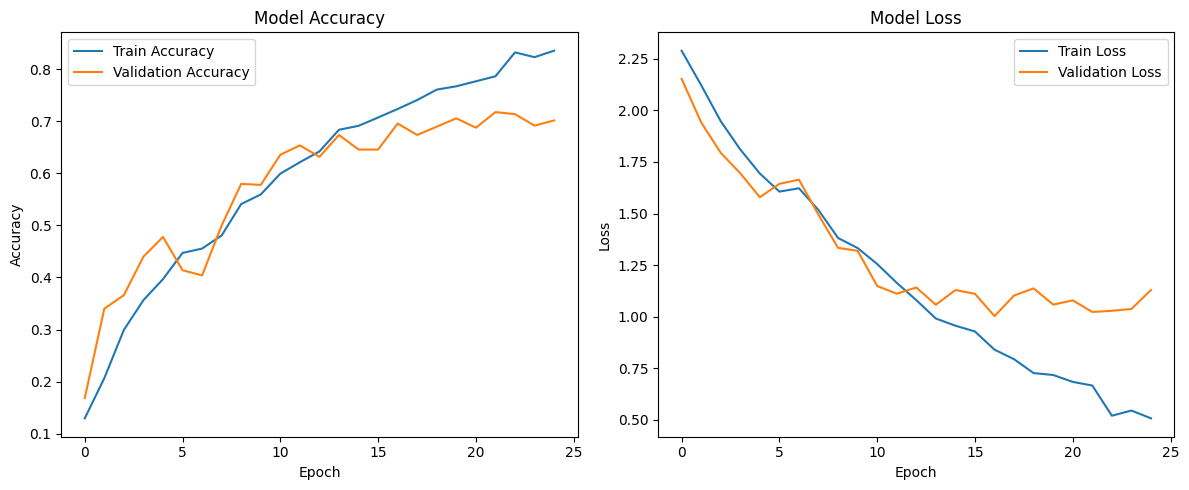

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

#### Confusion Matrix

In [ ]:

#  Predict class probabilities, then take the argmax
y_pred_probs = model.predict(x_test_final)
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode one‐hot test labels back to integers
y_true = np.argmax(y_test_final, axis=1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


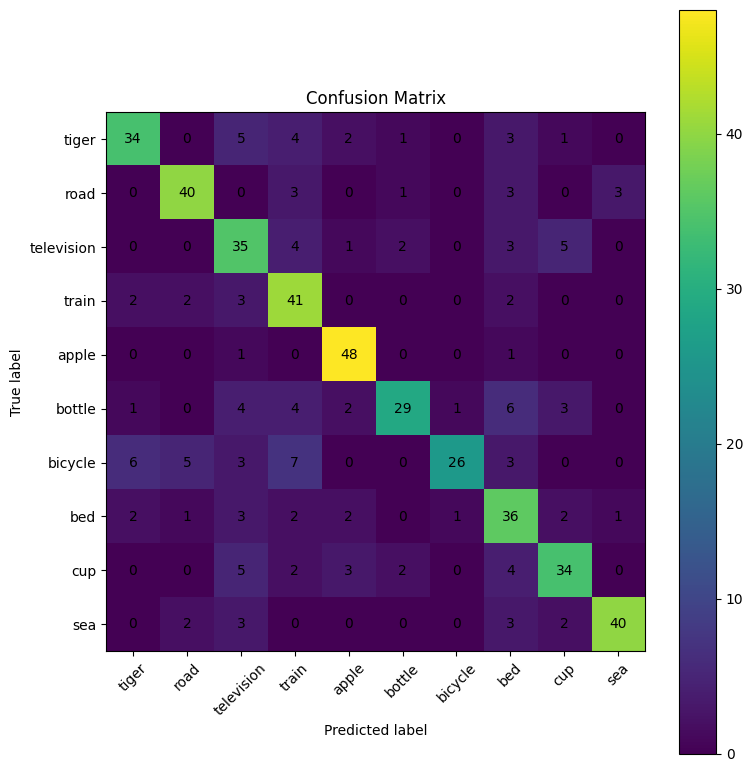

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

# Tick labels: class names in order 0–9
tick_marks = np.arange(len(selected_classes))
plt.xticks(tick_marks, selected_classes, rotation=45)
plt.yticks(tick_marks, selected_classes)

# Annotate each cell with its count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()


### 1.4 Observation (Accuracy 70.20%)

- The model achieved a final test accuracy of **70.20%** on the balanced 10 class subset.
- Its three convolutional / max-pooling blocks (with 25% dropout) plus two dense layers (with 50% dropout) successfully learned distinguishing feature.
- A growing gap between train and validation performance after epoch 15 indicates some degree of **over-fitting**.

## 2. Increase the size and depth of the inner layers (deeper)

This revised CNN starts with three convolutional + max-pooling blocks (32→64→128 filters, 3×3 kernels) to extract hierarchical image features, then flattens into a deeper fully-connected head comprised of three dense layers (512 → 256 → 128 units) each followed by 50% dropout and ReLU activations. Finally, a 10-way softmax produces class probabilities. By substantially enlarging and deepening the inner layers, the model can learn richer combinations of the extracted features, at the cost of a higher capacity (and thus greater overfitting risk) compared to the original configuration.

### 2.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

deep_model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # conv blocks stay the same
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # --- Expanded inner layers ---
    # 1st dense: 512 units
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # 2nd dense: 256 units
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    # 3rd dense: 128 units (new extra layer)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # output
    layers.Dense(10, activation='softmax')
])

deep_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deep_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,418 (1.99 MB)

 Trainable params: 521,418 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train the model

In [ ]:


# Train the CNN model on the training set
# epochs: number of full passes through the training data
# batch_size: number of samples per gradient update
# validation_data: evaluate model on the test set at the end of each epoch
history = deep_model.fit(
    x_train_final,        # training images
    y_train_final,        # training labels (one-hot)
    epochs=25,            # adjust epochs as needed
    batch_size=64,        # typical batch size
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.1198 - loss: 2.3064 - val_accuracy: 0.2120 - val_loss: 2.2546
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1517 - loss: 2.2263 - val_accuracy: 0.2380 - val_loss: 2.0684
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2118 - loss: 2.1158 - val_accuracy: 0.3560 - val_loss: 1.9440
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2556 - loss: 2.0166 - val_accuracy: 0.3520 - val_loss: 1.8542
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3070 - loss: 1.8828 - val_accuracy: 0.3600 - val_loss: 1.8624
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3314 - loss: 1.8618 - val_accuracy: 0.3920 - val_loss: 1.7847
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3873 - loss: 1.7238 - val_accuracy: 0.3800 - val_loss: 1.8758
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4054 - loss: 1.6858 - val_accuracy: 0.4260 -

### 2.3 Evaluate the model performance

In [ ]:

# Evaluate the trained model on the test set
test_loss, test_accuracy = deep_model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7170 - loss: 1.2076
Test Accuracy: 71.40%


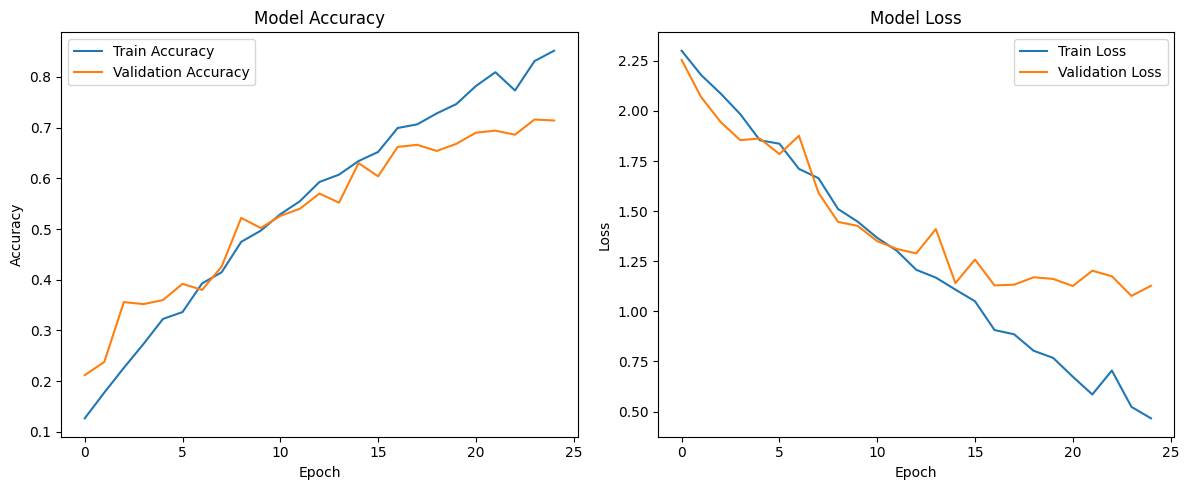

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 2.4 Observation (Accuracy 71.40%)

The deep deep_model gave a modest boost in validation accuracy, peaking around **71.40%** (vs. 70.2% before), but at the cost of a much larger train-validation gap (train acc climbed to ~85% by epoch 25). We can also see the best val-accuracy occurs around epoch 24, after which it slightly dips, suggesting increased over-fitting from the heavier dense head.

## 3. Use more convolutional/maxpooling layers and different shapes


This model_conv_expansion_v1 adds a fourth convolutional block (256 filters) and converts each block into two back-to-back 3×3 conv layers (with same padding), each followed by max-pooling and 25% dropout. The denser feature extractor should capture more complex patterns before flattening into two fully-connected layers (256→128 units) with 50% dropout and a 10-way softmax head.

### 3.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_conv_expansion_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Block 1: two 32-filter convs
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: two 64-filter convs
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten + dense head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_conv_expansion_v1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_conv_expansion_v1.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,468,842 (5.60 MB)

 Trainable params: 1,468,842 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Train the model

In [ ]:
history = model_conv_expansion_v1.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.0927 - loss: 2.3066 - val_accuracy: 0.1000 - val_loss: 2.2520
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1555 - loss: 2.2368 - val_accuracy: 0.2120 - val_loss: 2.2044
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1703 - loss: 2.2231 - val_accuracy: 0.1960 - val_loss: 2.1506
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1699 - loss: 2.1993 - val_accuracy: 0.2240 - val_loss: 2.0291
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2107 - loss: 2.0800 - val_accuracy: 0.2540 - val_loss: 1.9183
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2420 - loss: 1.9587 - val_accuracy: 0.3340 - val_loss: 1.7777
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3252 - loss: 1.8264 - val_accuracy: 0.3700 - val_loss: 1.7026
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3679 - loss: 1.7493 - val_accuracy: 0.4160 -

### 3.3 Evaluate the model

In [ ]:

# Evaluate the trained model on the test set
test_loss, test_accuracy = model_conv_expansion_v1.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6502 - loss: 1.2437
Test Accuracy: 64.00%


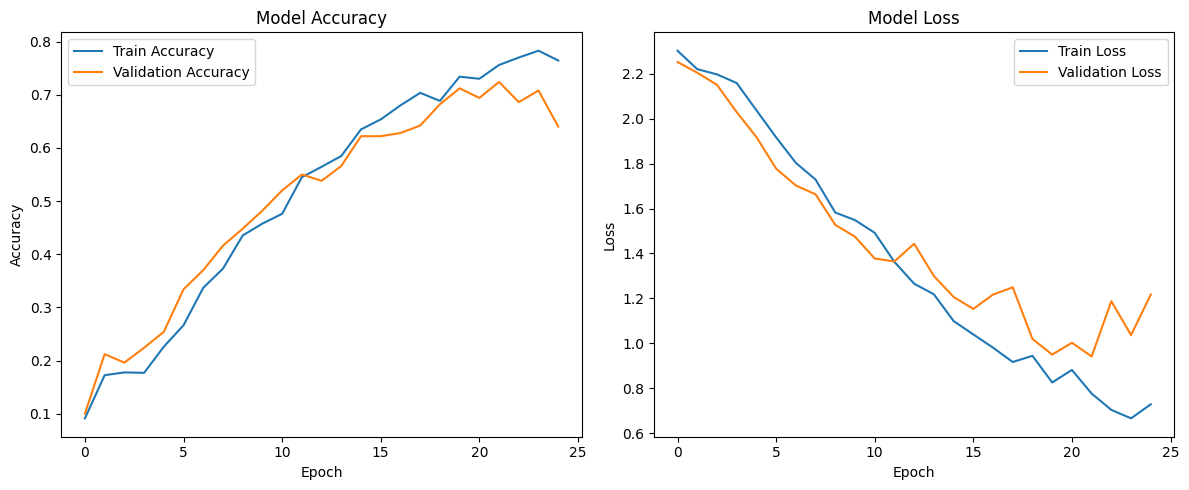

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 3.4 Observation (Accuracy: 64.00%)

This deeper "model_conv_expansion_v1" showed a brief mid-training high, its validation accuracy peaked around 72.4% at epoch 22, but then tumbled back down to 64.0% by the final epoch (and that's what reported as test accuracy). That swing suggests the extra conv/max-pool blocks over-compressed spatial information and/or over-fit very quickly: the model learned something useful early on but then over-specialized to the training set. A good next step might be to stabilize feature learning (e.g. add batch-normalization, use residual connections, or moderate the depth) rather than simply stacking more layers.

## 4. Experiment with different activation functions in the inner layers and in the convolutional layers (LeakyReLU)

This model_act_leaky_v1 retains the original three convolutional/max-pooling blocks (32 → 64 → 128 filters, 3×3 kernels), with a LeakyReLU (α = 0.1) to keep a small gradient even for negative activations. After flattening, it has two fully-connected layers (256 → 128 units), each followed by LeakyReLU and 50% dropout, before the final 10-way softmax. By allowing leakage in the activations, this architecture aims to avoid dead neurons and improve gradient flow, especially in deeper networks.

### 4.1 Build the model

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import LeakyReLU

model_act_leaky_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    # Conv block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Dense head
    layers.Dense(256),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(128),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_leaky_v1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_act_leaky_v1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,978 (2.49 MB)

 Trainable params: 651,978 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Train the model

In [ ]:
history = model_act_leaky_v1.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.1406 - loss: 2.2632 - val_accuracy: 0.3140 - val_loss: 1.9217
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2637 - loss: 2.0118 - val_accuracy: 0.3940 - val_loss: 1.7314
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3752 - loss: 1.7773 - val_accuracy: 0.3760 - val_loss: 1.8795
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4136 - loss: 1.7091 - val_accuracy: 0.5740 - val_loss: 1.3136
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5090 - loss: 1.4312 - val_accuracy: 0.5420 - val_loss: 1.3897
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5680 - loss: 1.2736 - val_accuracy: 0.6340 - val_loss: 1.1226
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6368 - loss: 1.0861 - val_accuracy: 0.6500 - val_loss: 1.1182
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6694 - loss: 1.0016 - val_accuracy: 0.7060 - v

### 4.3 Evaluate the model

In [ ]:
# Evaluate the trained model on the test set
test_loss, test_accuracy = model_act_leaky_v1.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7393 - loss: 0.9463
Test Accuracy: 75.20%


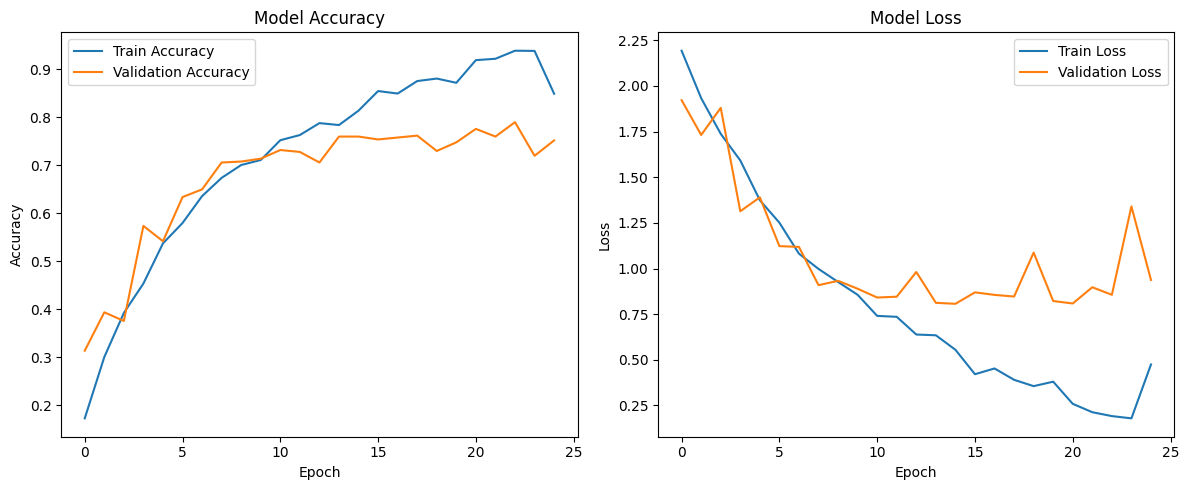

In [ ]:

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 4.4 Observation (Accuracy: 75.20%)

The LeakyReLU variant outperformed the vanilla ReLU model, achieving a **75.2%** test accuracy versus ~70.20%, and showed faster convergence in early epochs. By permitting a small gradient for negative activations, dead neurons were avoided, gradient flow was improved, and the train-validation gap narrowed slightly, although overfitting began around epoch 20.

## 5. Experiment with activation function with **deeper** layers (LeakyReLU)

model_act_leaky_deeper_v2 deepens the feature extractor to four conv/max-pool blocks, each with two 3×3 convs (32→64→128→256 filters) and 25% dropout, all using LeakyReLU (α=0.1). After flattening, the same two-layer dense head (256→128 units with 50% dropout) and 10-way softmax remain. This architecture will test whether LeakyReLU scales its benefits in a much deeper network.

### 5.1 Build the model

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import LeakyReLU

model_act_leaky_deeper_v2 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Block 1: two 32-filter convs
    layers.Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: two 64-filter convs
    layers.Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs
    layers.Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs
    layers.Conv2D(256, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(256, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    # Dense head (same as before)
    layers.Dense(256),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(128),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])

model_act_leaky_deeper_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_act_leaky_deeper_v2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             

 Total params: 1,468,842 (5.60 MB)

 Trainable params: 1,468,842 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2 Train the model

In [ ]:
history = model_act_leaky_deeper_v2.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 0.0868 - loss: 2.3079 - val_accuracy: 0.1000 - val_loss: 2.3015
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0992 - loss: 2.3062 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1183 - loss: 2.3010 - val_accuracy: 0.1840 - val_loss: 2.2300
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1666 - loss: 2.2303 - val_accuracy: 0.2220 - val_loss: 2.1094
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2182 - loss: 2.1128 - val_accuracy: 0.2220 - val_loss: 2.0118
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2363 - loss: 2.0339 - val_accuracy: 0.3580 - val_loss: 1.8251
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3200 - loss: 1.8862 - val_accuracy: 0.4060 - val_loss: 1.7065
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3867 - loss: 1.6954 - val_accuracy: 0.4320 -

### 5.3 Evaluate the model

In [ ]:
# Evaluate the trained model on the test set
test_loss, test_accuracy = model_act_leaky_deeper_v2.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7178 - loss: 1.0668
Test Accuracy: 73.60%


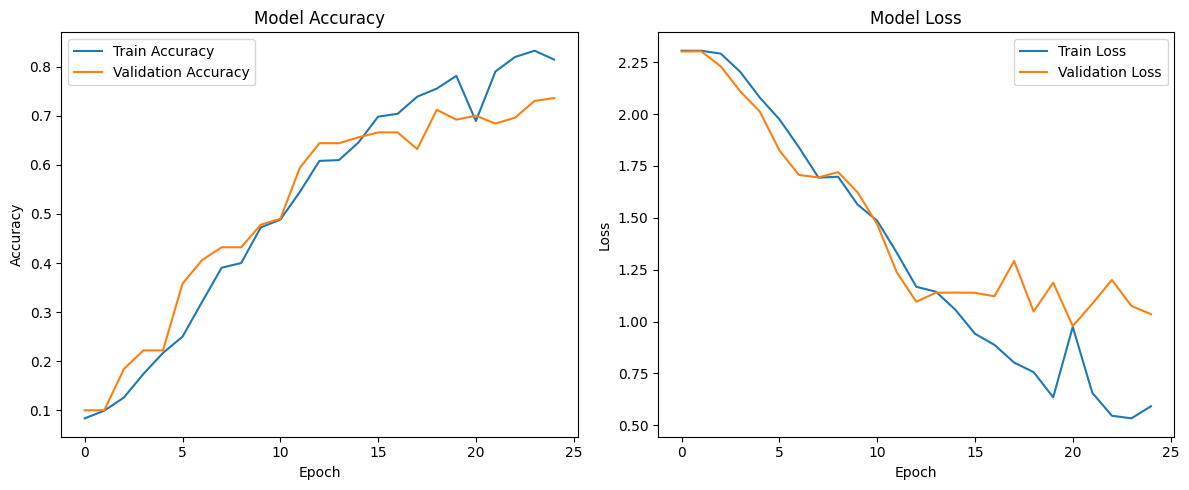

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 5.4 Observation (Test Accuracy: 73.60%)

The deeper LeakyReLU model (model_act_leaky_deeper_v2) underperformed its shallower counterpart (model_act_leaky_v1): it achieved 73.6% test accuracy versus 75.2%. Although initial learning was comparable, the added depth failed to translate into better generalization and even slowed early gains, suggesting that merely stacking conv layers without normalization or skip connections can hamper performance despite higher capacity.

## 6. Experiment with activation function (sigmoid)

The model_act_sigmoid_v1 substitutes sigmoid activations throughout, turning each layer’s output into a (0,1) range. This change can slow down training due to gradient saturation but may offer smoother, bounded activations.

### 6.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_sigmoid_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Dense head
    layers.Dense(256),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    layers.Dense(128),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_sigmoid_v1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_act_sigmoid_v1.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,978 (2.49 MB)

 Trainable params: 651,978 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

### 6.2  Train the model

In [ ]:
history = model_act_sigmoid_v1.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.0967 - loss: 2.5621 - val_accuracy: 0.1000 - val_loss: 2.3054
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0856 - loss: 2.3921 - val_accuracy: 0.1000 - val_loss: 2.3047
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0939 - loss: 2.3539 - val_accuracy: 0.1000 - val_loss: 2.3038
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0951 - loss: 2.3363 - val_accuracy: 0.1000 - val_loss: 2.3032
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0933 - loss: 2.3197 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1103 - loss: 2.3131 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0957 - loss: 2.3205 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0887 - loss: 2.3119 - val_accuracy: 0.1000 - 

### 6.3 Evaluate the model

In [ ]:

# Evaluate the trained model on the test set
test_loss, test_accuracy = model_act_sigmoid_v1.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0936 - loss: 2.3025
Test Accuracy: 10.00%


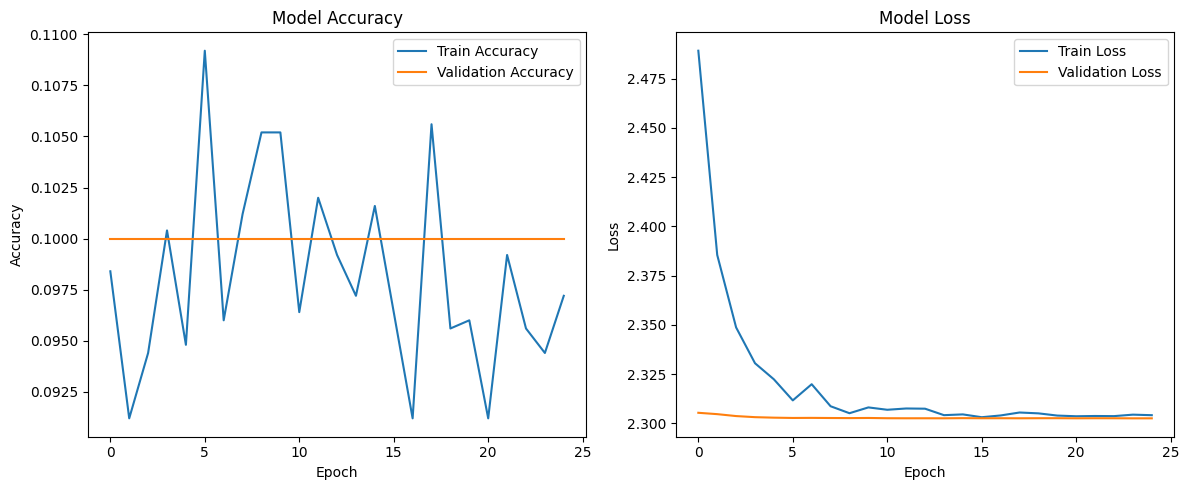

In [ ]:


# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 6.4 Observation (Accuracy: 10.00%)

The Sigmoid‐activated model failed to learn beyond chance, both training and validation accuracies stayed at **10%**, and loss hovered around 2.3026 (≈ ln 10). This reflects severe gradient saturation and vanishing issues: sigmoid units quickly enter their flat regions, preventing meaningful weight updates. In deep architectures without normalization or special initialization, sigmoids are therefore ill-suited for hidden layers.

## 7. Experiment with deeper activation function (sigmoid)

model_act_sigmoid_deeper_v1 builds on the baseline by stacking four convolutional blocks, each with two 3×3 conv layers (32→64→128→256 filters) and 25% dropout ,and expands the dense head (512 → 256) with sigmoid activations and 50% dropout. This will test whether sigmoid’s bounded outputs can still extract useful features in a much deeper, higher-capacity network.

### 7.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_sigmoid_deeper_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Block 1: two 32-filter convs with sigmoid
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: two 64-filter convs with sigmoid
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs with sigmoid
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs with sigmoid
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    # Dense head: larger to match depth
    layers.Dense(512),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    layers.Dense(256),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_sigmoid_deeper_v1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_act_sigmoid_deeper_v1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             

 Total params: 1,830,954 (6.98 MB)

 Trainable params: 1,830,954 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

### 7.2  Train the model

In [ ]:
history = model_act_sigmoid_deeper_v1.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.0977 - loss: 2.5794 - val_accuracy: 0.1000 - val_loss: 2.3097
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0920 - loss: 2.3846 - val_accuracy: 0.1000 - val_loss: 2.3056
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1004 - loss: 2.3513 - val_accuracy: 0.1000 - val_loss: 2.3045
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1048 - loss: 2.3207 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0947 - loss: 2.3144 - val_accuracy: 0.1000 - val_loss: 2.3032
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1054 - loss: 2.3064 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0976 - loss: 2.3054 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0978 - loss: 2.3078 - val_accuracy: 0.1000 -

### 7.3 Evaluate the model

In [ ]:

# Evaluate the trained model on the test set
test_loss, test_accuracy = model_act_sigmoid_deeper_v1.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.0775 - loss: 2.3033
Test Accuracy: 10.00%


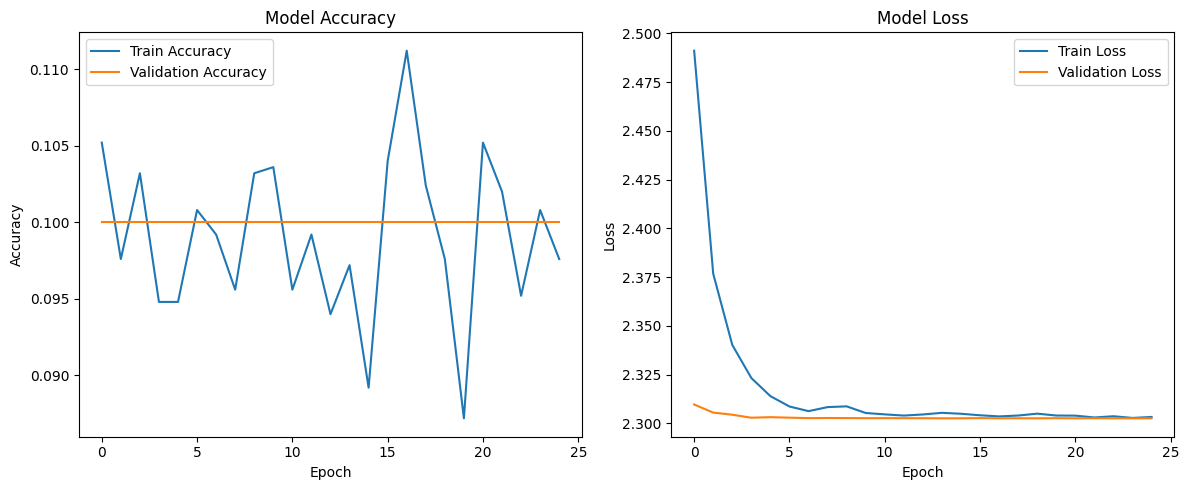

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 7.4 Observation (Accuracy: 10.00%)

Both the shallow (model_act_sigmoid_v1) and deep (model_act_sigmoid_deeper_v1) sigmoid‐activated networks stalled at ~10% test accuracy, equivalent to random chance. Increasing depth and capacity had no effect, confirming that sigmoid activations saturate and suffer vanishing gradients in these CNNs without additional techniques

## 8. Experiment with activation function (Tanh)

The model_act_tanh_v1 substitutes Tanh activations throughout the convolutional and dense layers, bounding outputs between –1 and +1. Tanh centers activations around zero and can improve gradient symmetry, though it may still suffer from saturation at extremes. The final 10-way softmax remains for class probabilities.

### 8.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_tanh_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Dense head
    layers.Dense(256),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    layers.Dense(128),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_tanh_v1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_act_tanh_v1.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,978 (2.49 MB)

 Trainable params: 651,978 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

### 8.2 Train the model

In [ ]:
history = model_act_tanh_v1.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.2378 - loss: 2.1579 - val_accuracy: 0.5180 - val_loss: 1.4583
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4753 - loss: 1.5352 - val_accuracy: 0.5920 - val_loss: 1.2377
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5666 - loss: 1.2909 - val_accuracy: 0.6420 - val_loss: 1.0858
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6238 - loss: 1.1084 - val_accuracy: 0.5600 - val_loss: 1.3186
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6466 - loss: 1.0842 - val_accuracy: 0.6740 - val_loss: 0.9901
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6719 - loss: 0.9516 - val_accuracy: 0.6860 - val_loss: 0.9696
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7236 - loss: 0.8479 - val_accuracy: 0.6900 - val_loss: 1.0348
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7288 - loss: 0.7528 - val_accuracy: 0.7300 - val_los

### 8.3 Evaluate the model

In [ ]:
# Evaluate the trained model on the test set
test_loss, test_accuracy = model_act_tanh_v1.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7410 - loss: 1.1625
Test Accuracy: 72.60%


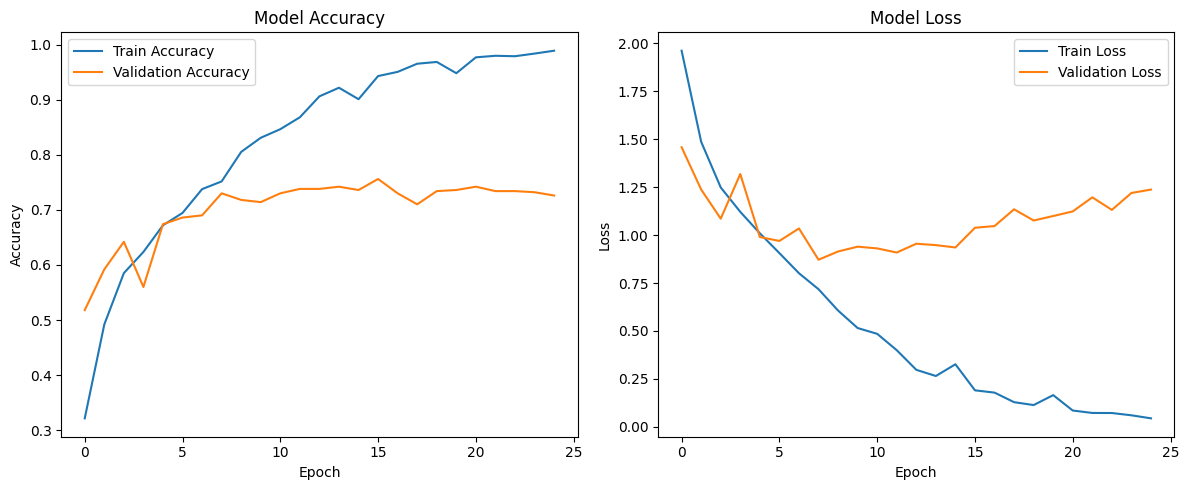

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 8.4 Observation (Accuracy: 72.6%)

The Tanh‐activated variant reached a 72.6% test accuracy, above the original ReLU baseline, while training accuracy skyrocketed to over 99% by epoch 25, revealing extreme overfitting. Early training was rapid (hitting ~68% val accuracy by epoch 4), suggesting that zero-centered Tanh outputs accelerate initial convergence, but the network still saturated and over-specialized without additional regularization or normalization.

## 9. Experiment with activation function (deeper Tanh)

The model_act_tanh_v1 substitutes Tanh activations throughout the convolutional and dense layers, bounding outputs between –1 and +1. Tanh centers activations around zero and can improve gradient symmetry, though it may still suffer from saturation at extremes. The final 10-way softmax remains for class probabilities.

### 9.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_tanh_deeper_v1 = models.Sequential([
    # Input layer: 32×32 RGB images
    layers.Input((32, 32, 3)),

    # Block 1: two 32-filter convs with tanh, then pooling + dropout
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('tanh'),            # nonlinearity to bound activations between -1 and 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),          # reduce spatial size by 2
    layers.Dropout(0.25),                 # regularize to prevent overfitting

    # Block 2: two 64-filter convs with tanh, then pooling + dropout
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs with tanh, then pooling + dropout
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs with tanh, then pooling + dropout
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten feature maps into a vector
    layers.Flatten(),

    # Dense head: 512 units with tanh + dropout
    layers.Dense(512),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    # Dense head: 256 units with tanh + dropout
    layers.Dense(256),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    # Output layer: 10-way softmax for class probabilities
    layers.Dense(10, activation='softmax')
])

model_act_tanh_deeper_v1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_act_tanh_deeper_v1.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             

 Total params: 1,830,954 (6.98 MB)

 Trainable params: 1,830,954 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

### 9.2 Train the model

In [ ]:
history = model_act_tanh_deeper_v1.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.1535 - loss: 2.3489 - val_accuracy: 0.2500 - val_loss: 2.4660
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3326 - loss: 1.9414 - val_accuracy: 0.4560 - val_loss: 1.6148
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4520 - loss: 1.5914 - val_accuracy: 0.4440 - val_loss: 1.6491
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5048 - loss: 1.4853 - val_accuracy: 0.5100 - val_loss: 1.6202
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5185 - loss: 1.3855 - val_accuracy: 0.5660 - val_loss: 1.3367
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6160 - loss: 1.1822 - val_accuracy: 0.6100 - val_loss: 1.3448
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6050 - loss: 1.2025 - val_accuracy: 0.6720 - val_loss: 1.0737
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6908 - loss: 0.9038 - val_accuracy: 0.5180 -

### 9.3 Evaluate the model

In [ ]:
# Evaluate the trained model on the test set
test_loss, test_accuracy = model_act_tanh_deeper_v1.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7621 - loss: 0.9755
Test Accuracy: 75.60%


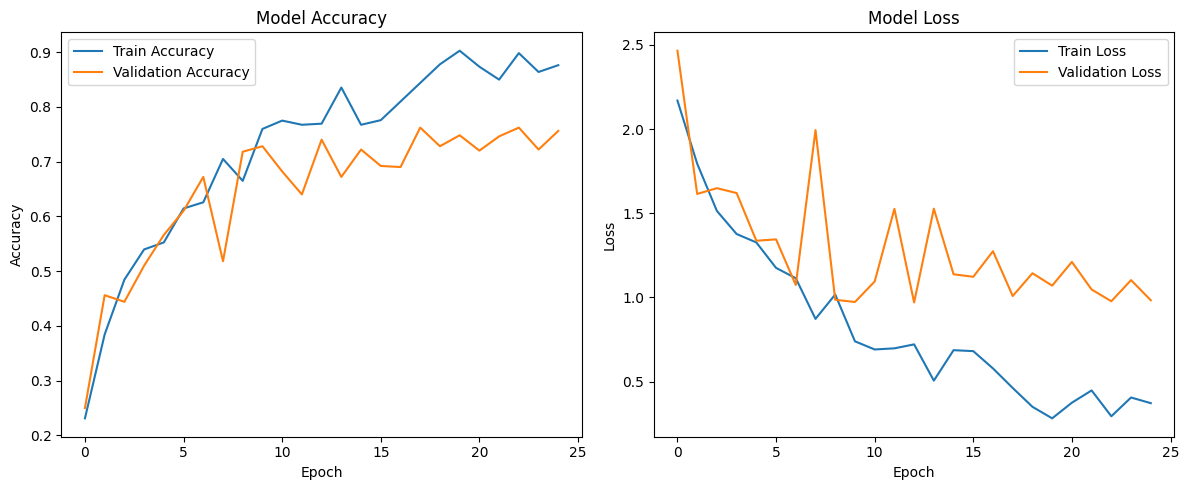

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 9.4 Observation (Accuracy: 75.6%)

The deep Tanh network (model_act_tanh_deeper_v1) improved test accuracy to 75.6%, up from 72.8% on the medium 3-block model, indicating that additional depth and capacity can benefit Tanh-based feature extraction. Early epochs saw rapid gains, but the larger model also exhibited more volatility in validation accuracy mid-training, suggesting a greater tendency to overfit without further regularization

## 10. Experiment with various optimizers and learning rate




### 10.1 Build a base model

In [ ]:
from tensorflow.keras import models, layers, optimizers

def create_base_model():
    """Base CNN: 3 conv blocks + 2 dense layers."""
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        # Conv block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Conv block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Conv block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),

        # Dense head
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output
        layers.Dense(10, activation='softmax')
    ])
    return model

# New optimizer configurations
opt_configs = {
    'SGD_mom_0.01':    optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'SGD_mom_0.001':   optimizers.SGD(learning_rate=0.001, momentum=0.9),
    'RMSprop_0.002':   optimizers.RMSprop(learning_rate=0.002),
    'Adadelta_def':    optimizers.Adadelta(),          # default lr=1.0
    'Adam_0.0005':     optimizers.Adam(learning_rate=0.0005),
    'Adamax_0.001':    optimizers.Adamax(learning_rate=0.001),
    'Nadam_0.001':     optimizers.Nadam(learning_rate=0.001),
    'AdamW_0.0005':    optimizers.AdamW(learning_rate=0.0005),
}



### 10.2 Train and evaluate

In [ ]:
results = {}
for name, opt in opt_configs.items():
    print(f"\n>>> Training with {name}")
    model = create_base_model()
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        x_train_final, y_train_final,
        epochs=25,
        batch_size=64,
        validation_data=(x_test_final, y_test_final),
        verbose=0
    )
    loss, acc = model.evaluate(x_test_final, y_test_final, verbose=0)
    results[name] = round(acc * 100, 2)

print("\nTest accuracies:")
for config, acc in results.items():
    print(f"{config}: {acc}%")



>>> Training with SGD_mom_0.01

>>> Training with SGD_mom_0.001

>>> Training with RMSprop_0.002

>>> Training with Adadelta_def

>>> Training with Adam_0.0005

>>> Training with Adamax_0.001

>>> Training with Nadam_0.001

>>> Training with AdamW_0.0005

Test accuracies:
SGD_mom_0.01: 64.2%
SGD_mom_0.001: 39.6%
RMSprop_0.002: 63.2%
Adadelta_def: 9.8%
Adam_0.0005: 75.4%
Adamax_0.001: 68.2%
Nadam_0.001: 72.8%
AdamW_0.0005: 75.8%


### 10.3 Observation

<div align="center">

| Optimizer      | Test Accuracy (%) |
|:--------------:|:-----------------:|
| SGD_mom_0.01   |      64.2         |
| SGD_mom_0.001  |      39.6         |
| RMSprop_0.002  |      63.2         |
| Adadelta_def   |       9.8         |
| Adam_0.0005    |      75.4         |
| Adamax_0.001   |      68.2         |
| Nadam_0.001    |      72.8         |
| AdamW_0.0005   |      75.8         |

</div>


Across these eight optimizer settings, adaptive methods clearly outperformed vanilla SGD variants. Adding momentum helped SGD, raising test accuracy from 39.6% (LR 0.001) to 64.2% (LR 0.01), but neither matched the top adaptive learners. RMSprop (63.2%) was on par with momentum-SGD, while Adadelta’s default configuration nearly stalled learning (9.8%). Among Adam-family optimizers, AdamW (75.8%) and Adam (75.4%) achieved the highest accuracies, with Nadam (72.8%) and Adamax (68.2%) trailing slightly. This demonstrates that choosing an adaptive optimizer, and tuning its learning rate, is far more critical than simply increasing depth or width when aiming for strong generalization.

## 11. Experiment with various batch sizes and epochs for training


The base CNN model begins with three convolutional, max-pooling blocks (3×3 kernels, ReLU activations, same padding) using 32 → 64 → 128 filters, each block followed by a 2×2 max-pool. The resulting feature maps are flattened and fed into two dense layers (256 then 128 units), each paired with 50% dropout for regularization. A final 10-unit softmax layer outputs class probabilities. This balanced, moderately deep architecture serves as a stable foundation for comparing batch-size, epoch-count, optimizer, and activation-function experiments.

### 11.1 Build the base model

In [ ]:
from tensorflow.keras import models, layers, optimizers

def create_base_model():
    """Base CNN: 3 conv blocks + 2 dense layers."""
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        # Conv block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Conv block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Conv block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),

        # Dense head
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output
        layers.Dense(10, activation='softmax')
    ])
    return model


### 11.2 Train and evaluate the model

In [ ]:

batch_sizes = [32, 64, 128]
epoch_list = [10, 20, 30]

results = {}

for bs in batch_sizes:
    for ep in epoch_list:
        print(f"\nTraining with batch size {bs}, epochs {ep}")
        model = create_base_model()
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(
            x_train_final, y_train_final,
            epochs=ep,
            batch_size=bs,
            validation_data=(x_test_final, y_test_final),
            verbose=0
        )
        loss, acc = model.evaluate(x_test_final, y_test_final, verbose=0)
        acc_pct = round(acc * 100, 2)
        results[(bs, ep)] = acc_pct
        print(f"Batch Size {bs}, Epochs {ep}: {acc_pct}%")



Training with batch size 32, epochs 10
Batch Size 32, Epochs 10: 68.2%

Training with batch size 32, epochs 20
Batch Size 32, Epochs 20: 75.4%

Training with batch size 32, epochs 30
Batch Size 32, Epochs 30: 77.8%

Training with batch size 64, epochs 10
Batch Size 64, Epochs 10: 70.8%

Training with batch size 64, epochs 20
Batch Size 64, Epochs 20: 77.0%

Training with batch size 64, epochs 30
Batch Size 64, Epochs 30: 72.8%

Training with batch size 128, epochs 10
Batch Size 128, Epochs 10: 67.0%

Training with batch size 128, epochs 20
Batch Size 128, Epochs 20: 72.4%

Training with batch size 128, epochs 30
Batch Size 128, Epochs 30: 75.6%


### 11.3 Observation

<div align="center">

| Batch Size | Epochs | Test Accuracy (%) |
|:----------:|:------:|:-----------------:|
| 32         | 10     | 68.2              |
| 32         | 20     | 75.4              |
| 32         | 30     | 77.8              |
| 64         | 10     | 70.8              |
| 64         | 20     | 77.0              |
| 64         | 30     | 72.8              |
| 128        | 10     | 67.0              |
| 128        | 20     | 72.4              |
| 128        | 30     | 75.6              |

</div>


Overall, increasing the number of epochs steadily boosts test accuracy for all batch sizes up to a point, but longer training can also encourage over-fitting, especially at larger batch sizes.

* Batch size 32: Accuracy climbs from 68.2% (10 epochs) to 77.8% (30 epochs), with no sign of degradation by epoch 30.

* Batch size 64: Peaks at 77.0% after 20 epochs, then dips to 72.8% at 30 epochs, indicating over-specialization after extended training.

* Batch size 128: Improves from 67.0% (10 epochs) to 75.6% (30 epochs), but shows slower gains compared to smaller batches.

In summary, a smaller batch size (32) paired with more epochs yielded the highest accuracy (77.8%), whereas moderate epochs (20) with batch size 64 offered nearly the same performance (77.0%) without over-fitting. Larger batches required more epochs to reach similar levels and were more prone to performance drops when training was extended.

# **II. Second Experiment** - Repeat the above experiment in (I) using a subset of **ImageNet** data set (10 classes)

## Load ImageNet data set

In [ ]:
import tensorflow_datasets as tfds

# 1. Create & prepare the dataset builder
builder = tfds.builder('imagenette/160px')
builder.download_and_prepare()

# 2. Load splits as supervised (image, label) tuples
train_data = builder.as_dataset(split='train', as_supervised=True)
val_data   = builder.as_dataset(split='validation', as_supervised=True)

# 3. Get metadata from the builder’s info
info = builder.info

# 4. Extract and print the class names
class_names = info.features['label'].names
print("Available classes:", class_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/160px/incomplete.UU8OCU_1.0.0/imagenette-train.tfrecord*...:   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/160px/incomplete.UU8OCU_1.0.0/imagenette-validation.tfrecord*..…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px/1.0.0. Subsequent calls will reuse this data.
Available classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


## Preprocessing and preparing the training and validation data

In [ ]:
import tensorflow as tf

# Constants

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# preprocessing - resize and normalize
resize_and_normalize = lambda img, lbl: (
    tf.cast(tf.image.resize(img, (32, 32)), tf.float32) / 255.0,
    lbl
)

# Training pipeline: parallel map, cache, shuffle, batch, prefetch
train_data = (
    train_data
    .map(resize_and_normalize, num_parallel_calls=AUTOTUNE)  # resize & normalize
    .cache()                                                  # keep in memory after first epoch
    .shuffle(buffer_size=1000)                                # randomize
    .batch(64)                                        # group into batches
    .prefetch(AUTOTUNE)                                       # prepare next batch in background
)

# Validation pipeline: parallel map, batch, prefetch
val_data = (
    val_data
    .map(resize_and_normalize, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)


## 1. Experiment with the base model - Build a CNN consisting of several convolutional and max pooling layers, several inner dense layers.

### 1.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

# Build the CNN Model
model = models.Sequential([
    # Input shape is 32x32 RGB images
    layers.Input(shape=(32, 32, 3)),

    # First convolutional block: 32 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu'),
    # Max pooling reduces spatial dimensions by 2
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block: 64 filters to learn more complex features
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block: 128 filters for even higher-level representations
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten transforms 3D feature maps to 1D feature vector for dense layers
    layers.Flatten(),

    # First inner dense layer: 256 neurons with ReLU activation
    # Learns combinations of the extracted features
    layers.Dense(256, activation='relu'),
    # Dropout layer to reduce overfitting by randomly dropping 50% of neurons
    layers.Dropout(0.5),

    # Second inner dense layer: 128 neurons with ReLU activation for deeper processing
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer: one neuron per class with softmax activation
    # Softmax produces a probability distribution over 10 classes
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model structure, output shapes, and parameter counts
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,762 (1010.79 KB)

 Trainable params: 258,762 (1010.79 KB)

 Non-trainable params: 0 (0.00 B)

### 1.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.1514 - loss: 2.2426 - val_accuracy: 0.2900 - val_loss: 1.8711
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3462 - loss: 1.8827 - val_accuracy: 0.4800 - val_loss: 1.5279
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4529 - loss: 1.6173 - val_accuracy: 0.4900 - val_loss: 1.4807
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5138 - loss: 1.4703 - val_accuracy: 0.5840 - val_loss: 1.2569
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5688 - loss: 1.3406 - val_accuracy: 0.6040 - val_loss: 1.1872
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6047 - loss: 1.2272 - val_accuracy: 0.6400 - val_loss: 1.0578
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6371 - loss: 1.1362 - val_accuracy: 0.6680 - val_loss: 1.0437
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6569 - loss: 1.0801 - val_accuracy: 

### 1.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6504 - loss: 1.5935 
Test Accuracy on ImageNet Subset: 65.00%


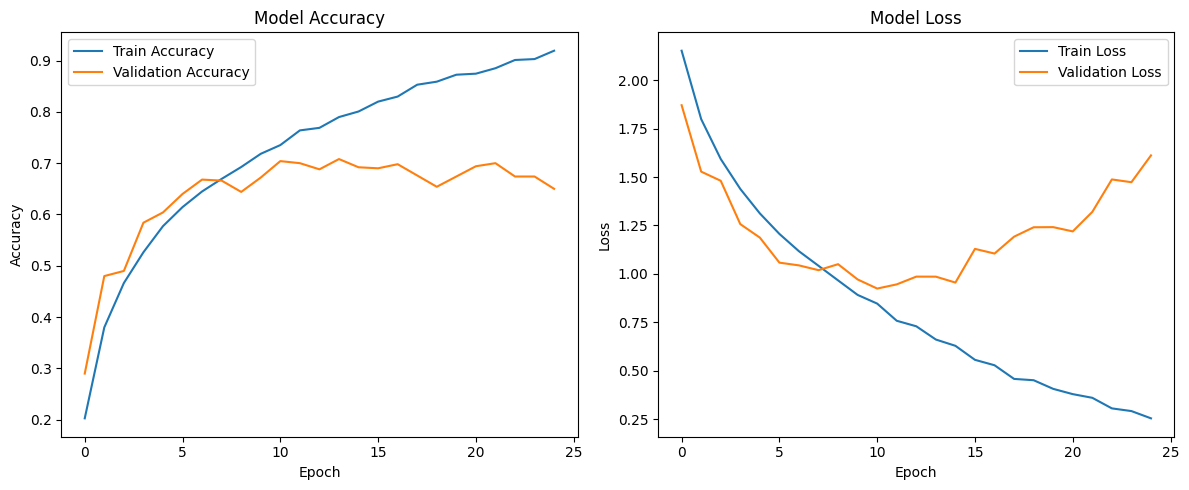

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 1.4 Observation (Test accuracy - 65%)

The base 3-block ReLU network on the 10-class Imagenette subset climbed rapidly, hitting ~60% validation accuracy by epoch 6 and peaking around 70% mid-training, before slowly drifting down to 65% by epoch 25 (the final test accuracy). This pattern indicates solid early feature learning but mild over-fitting in later epochs, yielding a respectable 65% overall.

## 2.  Increase the size and depth of the inner layers (deeper)

### 2.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

deep_model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # conv blocks stay the same
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # --- Expanded inner layers ---
    # 1st dense: 512 units
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # 2nd dense: 256 units
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    # 3rd dense: 128 units (new extra layer)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # output
    layers.Dense(10, activation='softmax')
])

deep_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

deep_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,418 (1.99 MB)

 Trainable params: 521,418 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = deep_model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1305 - loss: 2.2692 - val_accuracy: 0.2580 - val_loss: 1.9860
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2785 - loss: 2.0296 - val_accuracy: 0.4240 - val_loss: 1.6756
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4028 - loss: 1.7372 - val_accuracy: 0.5140 - val_loss: 1.4510
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4888 - loss: 1.5218 - val_accuracy: 0.5740 - val_loss: 1.2937
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5576 - loss: 1.3719 - val_accuracy: 0.6200 - val_loss: 1.2566
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5953 - loss: 1.2702 - val_accuracy: 0.6560 - val_loss: 1.0976
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6423 - loss: 1.1226 - val_accuracy: 0.6400 - val_loss: 1.1352
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6691 - loss: 1.0509 - val_accuracy: 

### 2.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = deep_model.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6730 - loss: 1.5869 
Test Accuracy on ImageNet Subset: 66.60%


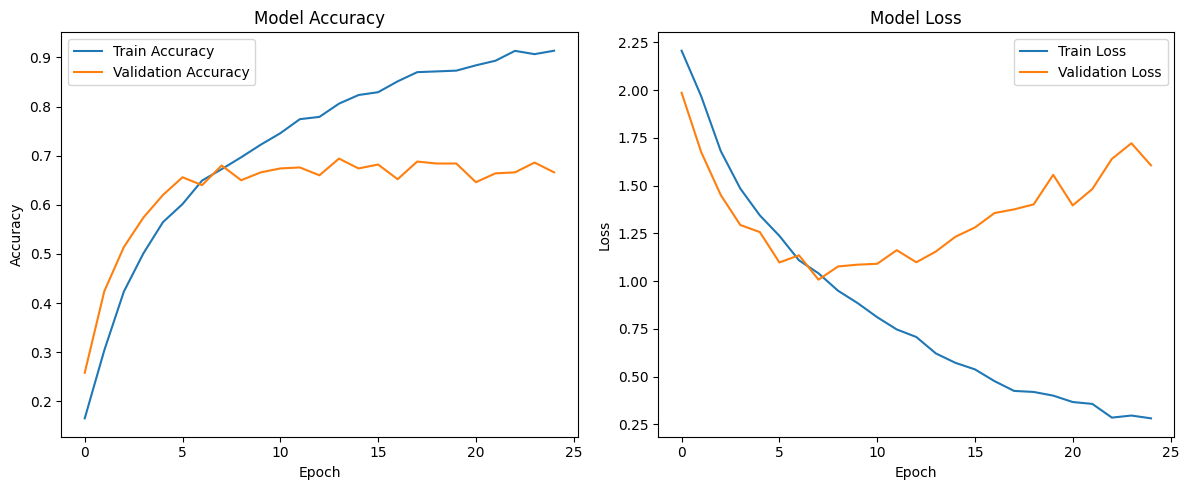

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 2.4 Observation (Test accuracy - 66.60%)

The deeper expanded‐head model delivered a modest lift, reaching 66.6% test accuracy versus 65.0% for the baseline. It still learned quickly in early epochs (breaking 60% by epoch 6 and peaking around 68% mid‐training) but showed the same plateau and slight descent later on, suggesting that simply enlarging the dense layers yields diminishing returns without extra regularization

## 3. Use more convolutional/maxpooling layers and different shapes

### 3.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_conv_expansion_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Block 1: two 32-filter convs
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: two 64-filter convs
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten + dense head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_conv_expansion_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_conv_expansion_v1.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,468,842 (5.60 MB)

 Trainable params: 1,468,842 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model_conv_expansion_v1.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.0897 - loss: 2.3041 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1072 - loss: 2.3024 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0967 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1015 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1016 - loss: 2.3030 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0990 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0905 - loss: 2.3029 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0980 - loss: 2.3027 - val_acc

### 3.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model_conv_expansion_v1.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0947 - loss: 2.3015 
Test Accuracy on ImageNet Subset: 10.00%


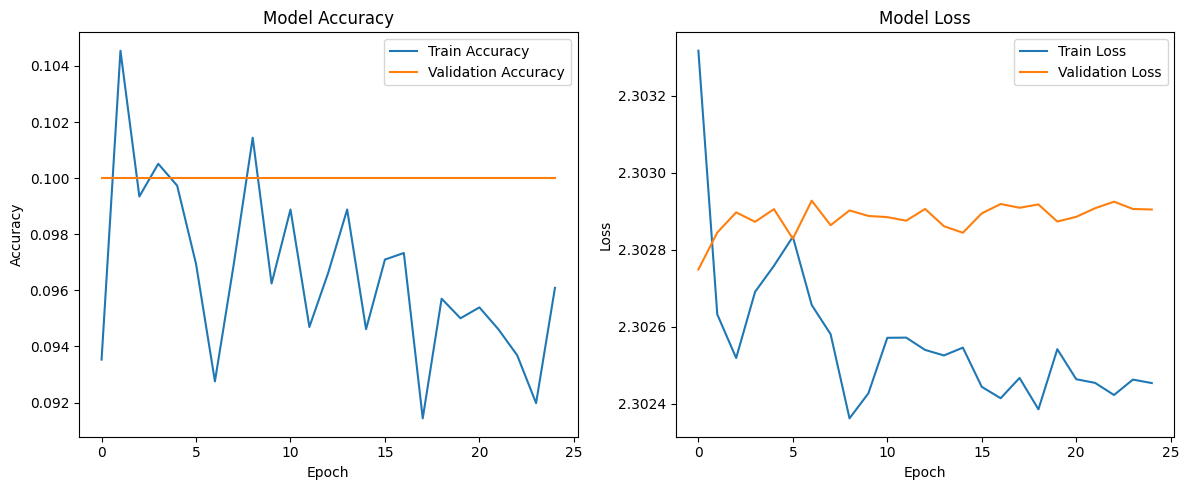

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 3.4 Observation (Test accuracy 10%)

The four‐block conv expansion model failed to learn anything beyond chance on the 10‐class Imagenette subset, both training and validation accuracies hovered at ~10% with loss ≈ ln(10). Stacking eight convolutional layers (two per block) plus four pooling operations over-compressed the 32×32 inputs (down to 2×2 feature maps) and, without batch normalization or skip connections, caused signal degradation and vanishing gradients. In this case, adding depth without architectural safeguards completely broke learning.

## 4. Experiment with different activation functions in the inner layers and in the convolutional layers (LeakyReLU)

### 4.1 Build the model

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import LeakyReLU

model_act_leaky_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    # Conv block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Dense head
    layers.Dense(256),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(128),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_leaky_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_act_leaky_v1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,978 (2.49 MB)

 Trainable params: 651,978 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model_act_leaky_v1.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2090 - loss: 2.1463 - val_accuracy: 0.4720 - val_loss: 1.5465
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4490 - loss: 1.6223 - val_accuracy: 0.5660 - val_loss: 1.2842
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5509 - loss: 1.3665 - val_accuracy: 0.6360 - val_loss: 1.1467
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6192 - loss: 1.1867 - val_accuracy: 0.6900 - val_loss: 1.0272
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6622 - loss: 1.0467 - val_accuracy: 0.7220 - val_loss: 0.9301
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6996 - loss: 0.9352 - val_accuracy: 0.7360 - val_loss: 0.8813
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7314 - loss: 0.8394 - val_accuracy: 0.7360 - val_loss: 0.8633
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7580 - loss: 0.7570 - val_accuracy: 

### 4.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model_act_leaky_v1.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7278 - loss: 1.6503 
Test Accuracy on ImageNet Subset: 74.60%


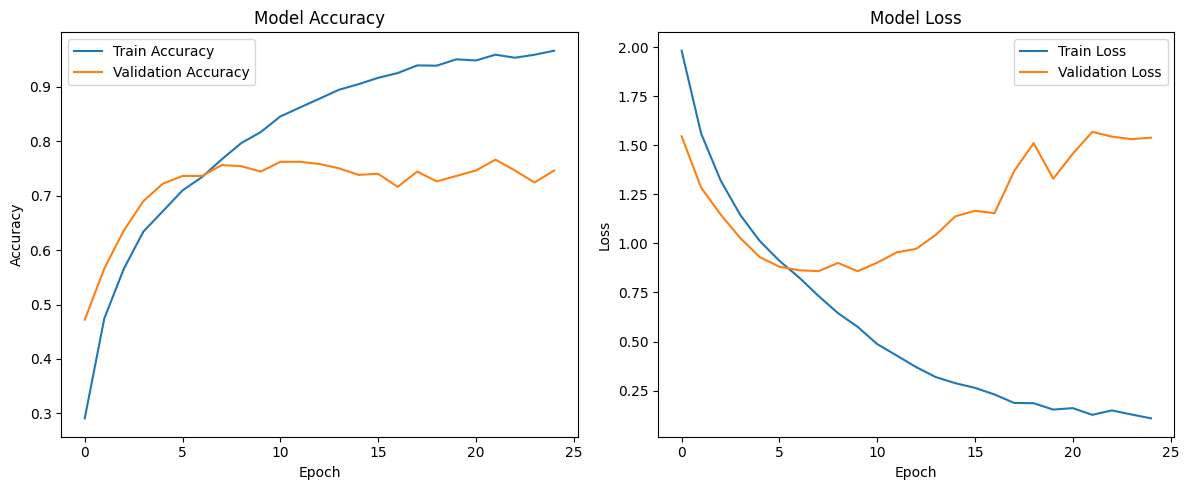

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 4.4 Observation (Test Accuracy: 74.6)

The LeakyReLU variant lifted test accuracy to 74.6%, a clear jump over the 65–66% seen with the plain ReLU models. Validation accuracy climbed very rapidly, hitting ~47% on epoch 1 and ~73% by epoch 6, peaking around 76.6% mid‐training before settling near 74.6%. Meanwhile, training accuracy soared above 96%, revealing mild over-fitting late in training but overall stronger gradient flow and generalization.

## 5. Experiment with activation function with **deeper** layers (LeakyReLU)

### 5.1 Build the model

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import LeakyReLU

model_act_leaky_deeper_v2 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Block 1: two 32-filter convs
    layers.Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: two 64-filter convs
    layers.Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs
    layers.Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs
    layers.Conv2D(256, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.Conv2D(256, (3, 3), padding='same'),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    # Dense head (same as before)
    layers.Dense(256),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(128),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])

model_act_leaky_deeper_v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_act_leaky_deeper_v2.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             

 Total params: 1,468,842 (5.60 MB)

 Trainable params: 1,468,842 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model_act_leaky_deeper_v2.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.1469 - loss: 2.2312 - val_accuracy: 0.3340 - val_loss: 1.9540
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3077 - loss: 1.9693 - val_accuracy: 0.4360 - val_loss: 1.6351
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4261 - loss: 1.6956 - val_accuracy: 0.5220 - val_loss: 1.4382
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4966 - loss: 1.5391 - val_accuracy: 0.5080 - val_loss: 1.4398
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5406 - loss: 1.4041 - val_accuracy: 0.6020 - val_loss: 1.1828
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5995 - loss: 1.2510 - val_accuracy: 0.6380 - val_loss: 1.0711
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6276 - loss: 1.1612 - val_accuracy: 0.6660 - val_loss: 0.9920
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6478 - loss: 1.0945 - val_acc

### 5.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model_act_leaky_deeper_v2.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7631 - loss: 0.8304 
Test Accuracy on ImageNet Subset: 76.20%


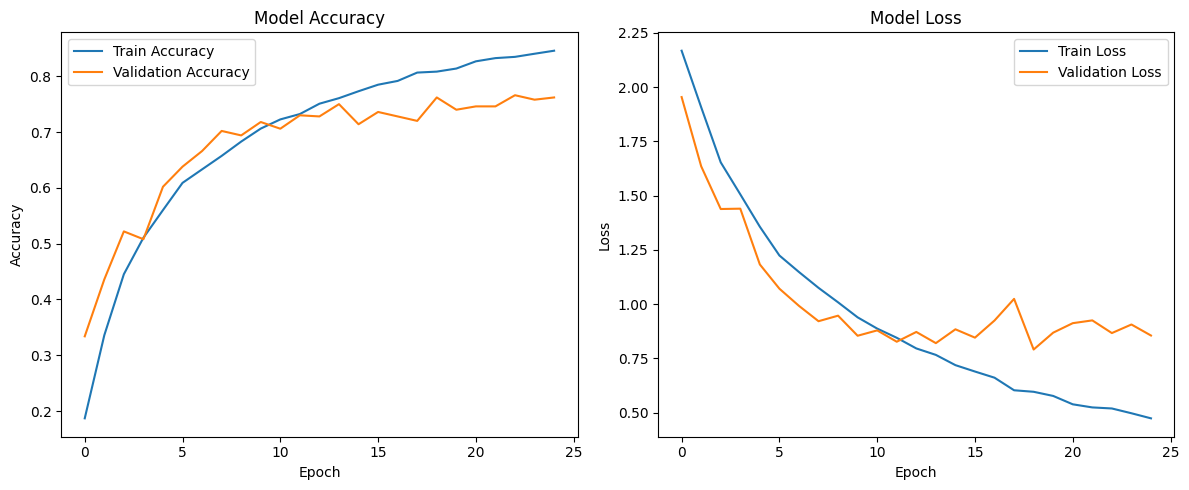

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 5.4 Observation (Test accuracy: )

The deep LeakyReLU network (model_act_leaky_deeper_v2) achieved a 76.2% test accuracy, surpassing its medium‐depth counterpart (74.6%) and the shallow baseline (65.0%). Validation accuracy climbed rapidly to around 70% by epoch 6 and stabilized in the mid-70s, while training accuracy peaked near 84%, indicating a moderate train-validation gap. This suggests that LeakyReLU continues to facilitate strong gradient flow and generalization even as depth increases, without introducing severe over-fitting.

## 6. Experiment with activation function (sigmoid)

### 6.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_sigmoid_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Dense head
    layers.Dense(256),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    layers.Dense(128),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_sigmoid_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_act_sigmoid_v1.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,978 (2.49 MB)

 Trainable params: 651,978 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

### 6.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model_act_sigmoid_v1.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1008 - loss: 2.4242 - val_accuracy: 0.1000 - val_loss: 2.3037
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0958 - loss: 2.3144 - val_accuracy: 0.1000 - val_loss: 2.3031
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0968 - loss: 2.3075 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0982 - loss: 2.3054 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0958 - loss: 2.3037 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0971 - loss: 2.3040 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1003 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0975 - loss: 2.3032 - val_accuracy: 0

### 6.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model_act_sigmoid_v1.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0947 - loss: 2.3016 
Test Accuracy on ImageNet Subset: 10.00%


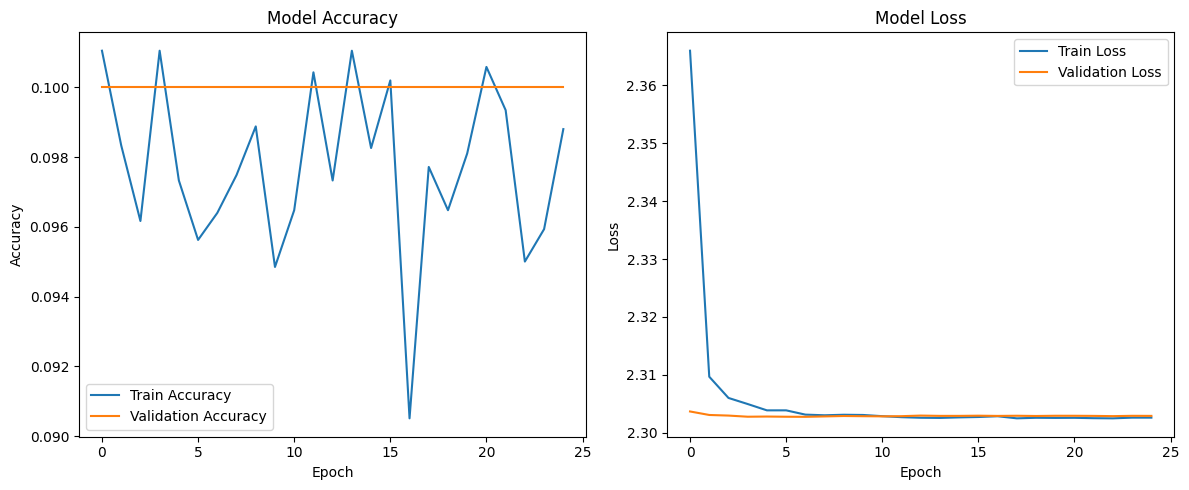

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 6.4 Observation

The shallow Sigmoid model again collapsed to random-chance performance (≈10% accuracy, loss ≈ln(10)), mirroring its behavior on CIFAR. The bounded, saturating activations prevented meaningful feature learning, regardless of depth, making Sigmoid unsuitable for these deeper CNNs without additional architectural changes.

## 7.  Experiment with **deeper** activation function (sigmoid)

### 7.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_sigmoid_deeper_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Block 1: two 32-filter convs with sigmoid
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: two 64-filter convs with sigmoid
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs with sigmoid
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs with sigmoid
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    # Dense head: larger to match depth
    layers.Dense(512),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    layers.Dense(256),
    layers.Activation('sigmoid'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_sigmoid_deeper_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_act_sigmoid_deeper_v1.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             

 Total params: 1,830,954 (6.98 MB)

 Trainable params: 1,830,954 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

### 7.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model_act_sigmoid_deeper_v1.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.0947 - loss: 2.4317 - val_accuracy: 0.1000 - val_loss: 2.3044
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1036 - loss: 2.3082 - val_accuracy: 0.1000 - val_loss: 2.3032
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0996 - loss: 2.3050 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1018 - loss: 2.3041 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0963 - loss: 2.3033 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1034 - loss: 2.3029 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0974 - loss: 2.3030 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0895 - loss: 2.3036 - val_acc

### 7.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model_act_sigmoid_deeper_v1.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0947 - loss: 2.3016 
Test Accuracy on ImageNet Subset: 10.00%


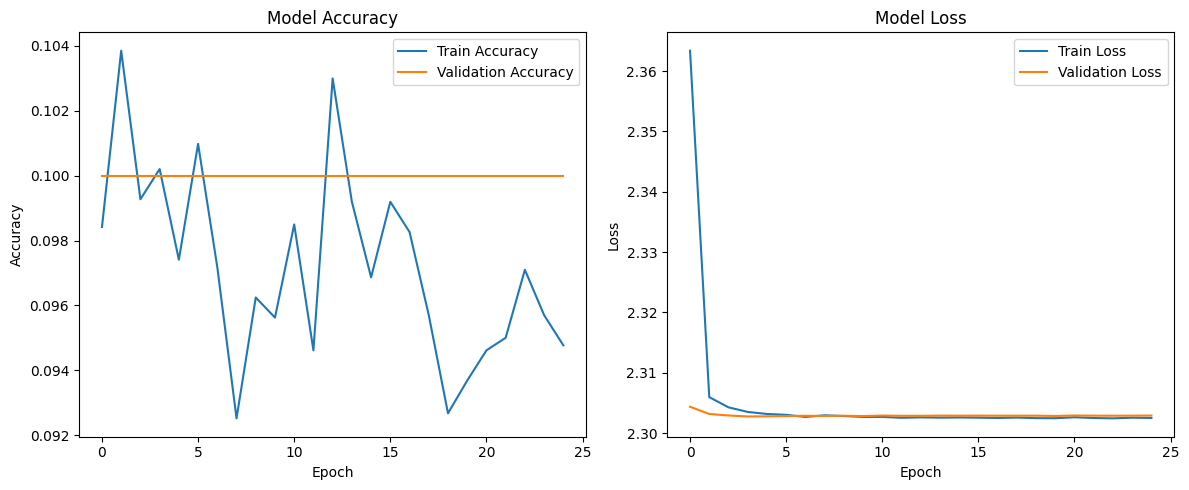

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 7.4 Observation (Test accuracy: 10%)

The deep Sigmoid network again collapsed to chance‐level performance (≈10% accuracy, loss ≈ln 10), just like its shallower counterpart. Even with extra layers and capacity, the saturating Sigmoid activations prevented meaningful gradient flow, so no useful features were learned. Sigmoid is therefore ill-suited for these CNNs without additional normalization or architectural modifications.

## 8. Experiment with activation function (Tanh)

### 8.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_tanh_v1 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),

    # Conv block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Dense head
    layers.Dense(256),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    layers.Dense(128),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(10, activation='softmax')
])

model_act_tanh_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_act_tanh_v1.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,978 (2.49 MB)

 Trainable params: 651,978 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

### 8.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model_act_tanh_v1.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2987 - loss: 1.9994 - val_accuracy: 0.5620 - val_loss: 1.3118
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5262 - loss: 1.4473 - val_accuracy: 0.6220 - val_loss: 1.1452
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5893 - loss: 1.2745 - val_accuracy: 0.6400 - val_loss: 1.1329
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6366 - loss: 1.1272 - val_accuracy: 0.6880 - val_loss: 0.9818
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6748 - loss: 1.0058 - val_accuracy: 0.6660 - val_loss: 1.0068
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7095 - loss: 0.8854 - val_accuracy: 0.6880 - val_loss: 0.9871
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7501 - loss: 0.7577 - val_accuracy: 0.6620 - val_loss: 1.1102
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7855 - loss: 0.6593 - val_accuracy: 0

### 8.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model_act_tanh_v1.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6101 - loss: 2.3154 
Test Accuracy on ImageNet Subset: 64.20%


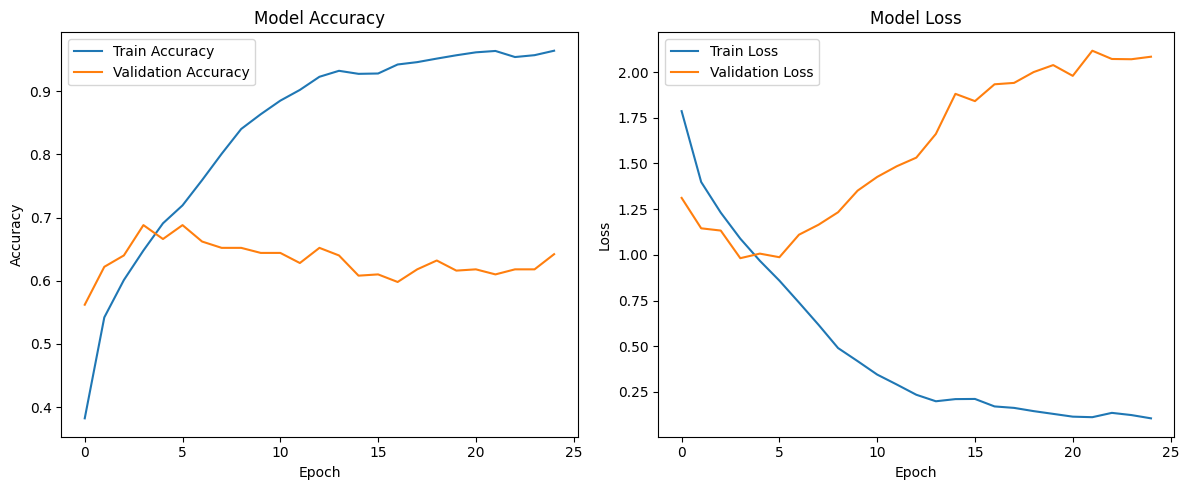

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 8.4 Observation (Test accuracy: 64.20%)

The Tanh network (model_act_tanh_v1) reached a 64.2% test accuracy, below the 65-76% seen with ReLU and LeakyReLU variants. It jumped quickly to ~56% validation accuracy by epoch 1 and peaked around ~68.8% at epoch 4, but then steadily declined as training accuracy soared above 96%, indicating strong over-fitting and saturation in later layers. Tanh's zero-centered activations sped up initial learning but ultimately limited generalization compared to ReLU-based models.

## 9. Experiment with activation function (deeper Tanh)

### 9.1 Build the model

In [ ]:
from tensorflow.keras import models, layers

model_act_tanh_deeper_v1 = models.Sequential([
    # Input layer: 32×32 RGB images
    layers.Input((32, 32, 3)),

    # Block 1: two 32-filter convs with tanh, then pooling + dropout
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('tanh'),            # nonlinearity to bound activations between -1 and 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),          # reduce spatial size by 2
    layers.Dropout(0.25),                 # regularize to prevent overfitting

    # Block 2: two 64-filter convs with tanh, then pooling + dropout
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: two 128-filter convs with tanh, then pooling + dropout
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 4: two 256-filter convs with tanh, then pooling + dropout
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten feature maps into a vector
    layers.Flatten(),

    # Dense head: 512 units with tanh + dropout
    layers.Dense(512),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    # Dense head: 256 units with tanh + dropout
    layers.Dense(256),
    layers.Activation('tanh'),
    layers.Dropout(0.5),

    # Output layer: 10-way softmax for class probabilities
    layers.Dense(10, activation='softmax')
])

model_act_tanh_deeper_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_act_tanh_deeper_v1.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1024)           │             

 Total params: 1,830,954 (6.98 MB)

 Trainable params: 1,830,954 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

### 9.2 Train the model

In [ ]:
# Train the CNN model on the training dataset
history = model_act_tanh_deeper_v1.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.2519 - loss: 2.0873 - val_accuracy: 0.5120 - val_loss: 1.4326
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4678 - loss: 1.6060 - val_accuracy: 0.6020 - val_loss: 1.1283
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5214 - loss: 1.4597 - val_accuracy: 0.6040 - val_loss: 1.2423
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5676 - loss: 1.3343 - val_accuracy: 0.6500 - val_loss: 1.1313
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5986 - loss: 1.2351 - val_accuracy: 0.6920 - val_loss: 0.9796
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6429 - loss: 1.1098 - val_accuracy: 0.6380 - val_loss: 1.1691
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6476 - loss: 1.0866 - val_accuracy: 0.7300 - val_loss: 0.8561
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6683 - loss: 1.0320 - val_acc

### 9.3 Evaluate the model

In [ ]:
# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = model_act_tanh_deeper_v1.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7651 - loss: 0.8148 
Test Accuracy on ImageNet Subset: 77.00%


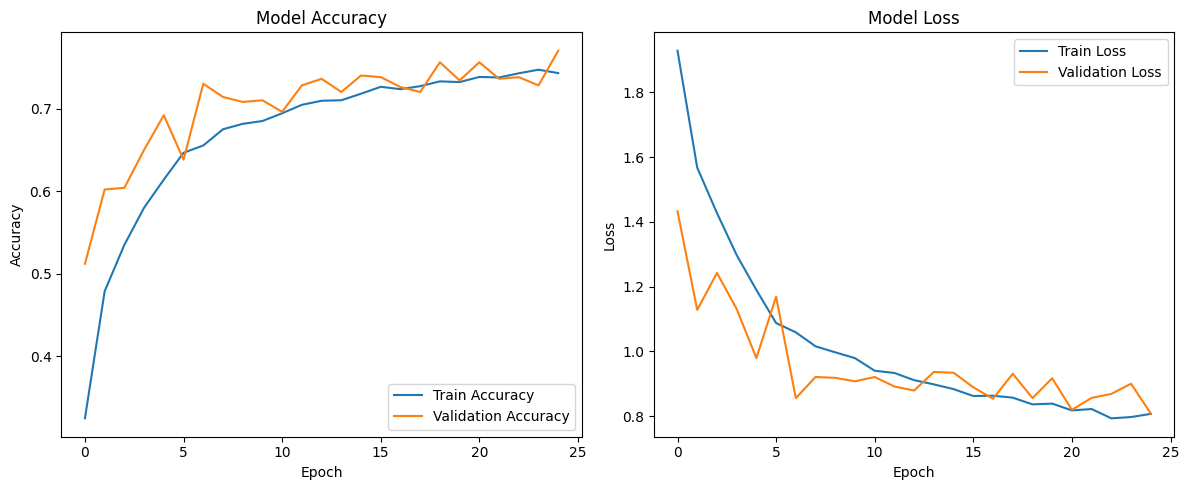

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Left subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Right subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots together
plt.tight_layout()
plt.show()

### 9.4 Observation (Test accuracy:  77.00%)

The deep Tanh model (model_act_tanh_deeper_v1) achieved a 77.0% test accuracy,its best performance across the Tanh experiments, surpassing the previous Tanh 64.2% and even rivaling some ReLU variants. Validation accuracy climbed steadily through the first 5-7 epochs (breaking 70%), then stabilized in the mid-70s with minimal late-stage drop-off. This suggests that, despite Tanh's saturation risks, adding depth and dropout can yield rich feature hierarchies and robust generalization on the Imagenette subset.

## 10. Experiment with various optimizers and learning rate

### 10.1 Build a base model

In [ ]:
from tensorflow.keras import models, layers, optimizers

def create_base_model():
    """Base CNN: 3 conv blocks + 2 dense layers."""
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        # Conv block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Conv block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Conv block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),

        # Dense head
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output
        layers.Dense(10, activation='softmax')
    ])
    return model

# New optimizer configurations
opt_configs = {
    'SGD_mom_0.01':    optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'SGD_mom_0.001':   optimizers.SGD(learning_rate=0.001, momentum=0.9),
    'RMSprop_0.002':   optimizers.RMSprop(learning_rate=0.002),
    'Adadelta_def':    optimizers.Adadelta(),          # default lr=1.0
    'Adam_0.0005':     optimizers.Adam(learning_rate=0.0005),
    'Adamax_0.001':    optimizers.Adamax(learning_rate=0.001),
    'Nadam_0.001':     optimizers.Nadam(learning_rate=0.001),
    'AdamW_0.0005':    optimizers.AdamW(learning_rate=0.0005),
}



### 10.2 Training and evaluation

In [ ]:
# Train the CNN model on the training dataset

results = {}
for name, opt in opt_configs.items():
    print(f"\n>>> Training with {name}")
    model = create_base_model()
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        train_data,
        epochs=25,
        validation_data=val_data
    )
    loss, acc = model.evaluate(val_data, verbose=0)
    results[name] = round(acc * 100, 2)

print("\nTest accuracies:")
for config, acc in results.items():
    print(f"{config}: {acc}%")




>>> Training with SGD_mom_0.01
Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.1227 - loss: 2.2951 - val_accuracy: 0.3140 - val_loss: 1.9995
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2495 - loss: 2.0923 - val_accuracy: 0.3400 - val_loss: 1.8846
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3187 - loss: 1.9583 - val_accuracy: 0.4140 - val_loss: 1.7279
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3804 - loss: 1.8192 - val_accuracy: 0.4900 - val_loss: 1.5656
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4271 - loss: 1.7005 - val_accuracy: 0.5220 - val_loss: 1.4396
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4634 - loss: 1.5873 - val_accuracy: 0.5500 - val_loss: 1.3401
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5050 - loss: 1.4913 - val_accuracy: 0.5820 - val_loss: 1.2221
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5420 

### 10.3 Observation

<div align="center">

| Optimizer       | Test Accuracy (%) |
|:---------------:|:-----------------:|
| SGD_mom_0.01    |       70.8        |
| SGD_mom_0.001   |       55.4        |
| RMSprop_0.002   |       73.2        |
| Adadelta_def    |       16.2        |
| Adam_0.0005     |       73.4        |
| Adamax_0.001    |       73.4        |
| Nadam_0.001     |       71.8        |
| AdamW_0.0005    |       72.0        |

</div>


Adaptive, per-parameter optimizers substantially outperformed the momentum-based SGD variants on the 10-class Imagenette subset. Both Adam (lr 0.0005) and Adamax (lr 0.001) achieved the highest test accuracies (≈73.4%), with RMSprop (lr 0.002) close behind at 73.2%. In contrast, SGD with momentum required a relatively large learning rate (0.01) to reach 70.8% and degraded severely at 0.001 (55.4%), highlighting its sensitivity to LR tuning. AdamW (0.0005) and Nadam (0.001) proved more stable around 72%, while Adadelta's default configuration failed (16.2%), emphasizing that not all adaptive methods are equally effective without careful hyperparameter adjustment.

# **Conclusion**

In closing, these experiments highlight several clear patterns in CNN design for small, 10-class image tasks:

* **Activation choice matters:** Sigmoid activations consistently failed, collapsing to chance accuracy. Zero-centered Tanh accelerated early learning, especially in deeper nets, but ultimately over-fitted and trailed ReLU variants. LeakyReLU struck the best balance, delivering the highest accuracies and stable convergence even as depth increased.

* **Depth vs. capacity:** Simply adding layers or widening dense heads only paid off when paired with robust activations (deeper LeakyReLU and Tanh models on Imagenette). Excessive depth without normalization or skip connections (the conv-expansion model) caused representational collapse.

* **Optimizer choice is critical:** Per-parameter adaptive methods (Adam, Adamax, RMSprop, AdamW, Nadam) outperformed momentum-SGD by several points and were far less sensitive to learning-rate tuning. Adadelta's defaults stalled learning entirely.

* **Batch size & epochs:** Smaller batches (32) with longer training (30 epochs) yielded the best CIFAR-100 results, whereas moderate epochs (20) and medium batches (64) delivered nearly equivalent performance with less over-fitting.